# Workbook 3

In [280]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from scipy.fftpack import fft, ifft, fftfreq

## Part b)

In [281]:
# Final time of the simulation
final_time = 50.

# Number of points in the computational grid
#Nx = 32
Nx = 256

# CFL factor
#CFL = .2
CFL = .1
#CFL = .05


# PDE Parameters
U0 = 0.1
Lx = 10.

# dx and dt
delta_x = Lx / Nx
delta_t = CFL * delta_x / U0

print("Delta t = {0:g}, Delta x = {1:g}".format(delta_t, delta_x))

# Create spatial grid
x = np.arange(delta_x / 2. - Lx/2, Lx/2, delta_x)

# Specify the number of time points to store (Nouts)
#  they will be equally spaced throughout the simulation.
Nouts = 200
output_interval = final_time / Nouts
t = np.zeros(Nouts + 1)
t[0] = 0.

# Create an array to store the solution, and write in the initial conditions
solution = np.zeros((Nouts + 1,Nx))
solution[0,:] = np.sin( 4 * np.pi * x / Lx ) + 0.25 * np.sin( 8 * np.pi * x / Lx )

Delta t = 0.0390625, Delta x = 0.0390625


## Plot Initial Conditions for Reference

Text(0.5, 1.0, 'IC: ($N_x=256$, CFL=0.1)')

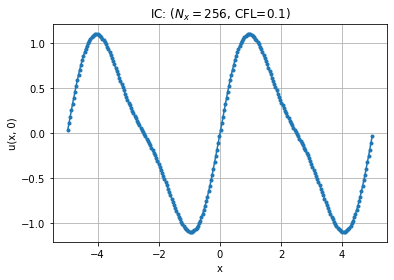

In [282]:
plt.plot( x, solution[0,:], '.-' )
plt.grid()
plt.xlabel('x')
plt.ylabel('u(x, 0)')
plt.title('IC: ($N_x={0}$, CFL={1})'.format(Nx, CFL))

#plt.savefig('IC_CFL05', bbox_inches="tight")

## Create a function to compute derivatives

We'll tidy things up a bit (and so make our time-stepping code a little bit easier to read) by wrapping our derivative code up into a function.

In [283]:
def ddx(f, dx = delta_x):

    dfdx = ( np.roll( f, -1 ) - np.roll(f, 1) ) / (2 * dx)
    
    return dfdx

## Compute Numerical Solution

In [284]:
curr_time = t[0]
u = solution[0,:]

next_output_time = output_interval
output_number = 0
while curr_time < final_time:
    
    # Compute the RHS of the ODE
    dudt = - U0 * ddx( u )
    
    # Update first-order record
    u = u + delta_t * dudt
    
    # Increase 'time' by Delta t
    curr_time = curr_time + delta_t
    
    # Store the new values in our array, if at the right time
    if curr_time >= next_output_time:
        output_number = output_number + 1
        next_output_time += output_interval
        
        solution[output_number,:] = u
        t[output_number] = curr_time
    
# Helps to avoid odd errors from funky step sizes
t = t[:output_number]
solution = solution[:output_number,:]

In [285]:
print( "The stored solution has {0:d} time points and {1:d} space points.".format(*solution.shape) )

The stored solution has 200 time points and 256 space points.


## Plot the Solution

<ipython-input-286-82107f8f4169>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh( x, t, solution, vmin = -cv, vmax = cv)


Text(0.5, 1.0, 'Solution: ($N_x=256$, CFL=0.1)')

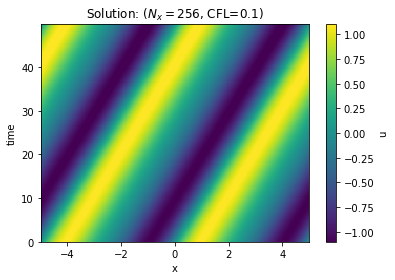

In [286]:
cv = np.max( np.abs( solution[0,:] ) )
plt.pcolormesh( x, t, solution, vmin = -cv, vmax = cv)

cbar = plt.colorbar()
cbar.ax.set_ylabel('u')

plt.xlabel('x')
plt.ylabel('time')
plt.title('Solution: ($N_x={0}$, CFL={1})'.format(Nx, CFL))

#plt.savefig('Solution_CFL05', bbox_inches="tight")

## Save the Data

In [287]:
# If we want to save the data to a file to analyze later, we can do that below.
#   Reading the data is similar to workbook 2

# This will save
#   - solution as 'u'
#   - t as 'time'
#   - x as 'x'
#   - U0 and 'U0'
np.savez('advection_data.npz', u = solution, time = t, x = x, U0 = U0)

## Part c)

In [288]:
true_sol = np.zeros_like(solution)

for i in range(len(t)):
    for j in range(len(x)):
        true_sol[i,j] = np.sin( 4 * np.pi * (x[j] - U0*t[i]) / Lx ) + 0.25 * np.sin( 8 * np.pi * (x[j] - U0*t[i]) / Lx )

In [289]:
rms = []

for i in range(len(t)):
    rms.append( np.sqrt( np.mean( (np.subtract(true_sol[i,:], solution[i,:]) )**2) ) )

rms_ic = np.sqrt( np.mean(solution[0,:]**2))
rms_ic

0.7288689868556626

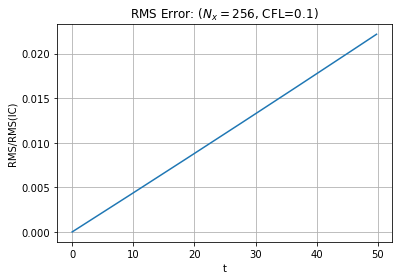

In [290]:
plt.plot( t, rms/rms_ic, '-')
#plt.plot( t, rms, '-')
plt.grid()
plt.xlabel('t')
plt.ylabel('RMS/RMS(IC)')
plt.title('RMS Error: ($N_x={0}$, CFL={1})'.format(Nx, CFL))

plt.savefig('RMS_Error_CFL01', bbox_inches="tight")

## Part d)

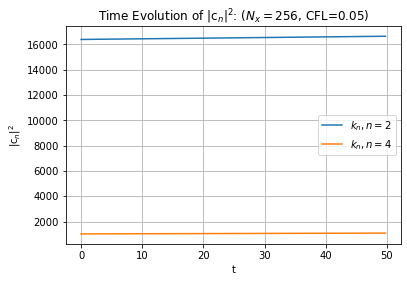

In [275]:
u_hat = fft(solution)
plt.plot(t, np.abs(u_hat[:,2])**2, label = '$k_n,n=2$')
plt.plot(t, np.abs(u_hat[:,4])**2, label = '$k_n,n=4$')
plt.grid()
plt.xlabel('t')
plt.ylabel('|c$_n$|$^2$')
plt.title('Time Evolution of |c$_n$|$^2$: ($N_x={0}$, CFL={1})'.format(Nx, CFL))
plt.legend()

#plt.savefig('C_n^2_CFL01', bbox_inches="tight")

Text(0.5, 1.0, 'Spectral Power Solution: ($N_x=256$, CFL=0.05)')

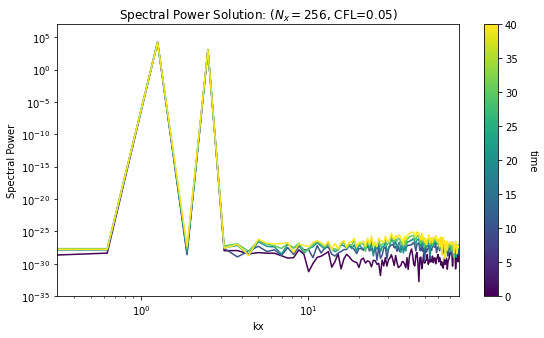

In [276]:
kx = 2*np.pi*fftfreq(Nx, d=delta_x)

fig, ax = plt.subplots(1, 1, figsize = (9,5))

plot_inds = np.arange(0, 200, 40)

# [:Nx//2] takes only the first half of all values in the array in question which is just all positive values, 
# we can do that because we know the negative values have the same magnitude as the positive ones
# We use fft function to return the Cn fourier coefficent terms, 
u_lines = [np.column_stack([kx[:Nx//2], np.abs(fft(solution[ii,:])[:Nx//2])**2]) for ii in plot_inds]

# Create a LineCollection object which holds them together
u_segments = LineCollection(u_lines, cmap = matplotlib.cm.viridis)

 # Set which variable is used with the colour map (determines colours)
u_segments.set_array(t[plot_inds])

# Plot the lines
ax.add_collection(u_segments)

# Need to manually update the bounds
ax.axis('tight')

# Add a colour bar showing time
cbar = plt.colorbar(u_segments, ax = ax)
cbar.ax.set_ylabel('time', rotation = -90, labelpad = 20)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('kx')
plt.ylabel('Spectral Power')
ax.set_xlim(10**-0.5, max(kx[:Nx//2]))
#ax.set_xlim([10**-0.5, 10**2])
ax.set_ylim([10**-35, 10**7])
ax.set_title('Spectral Power Solution: ($N_x={0}$, CFL={1})'.format(Nx, CFL))

#plt.savefig('Spectral_CFL05', bbox_inches="tight")

Text(0.5, 1.0, 'E v. t: ($N_x=256$, CFL=0.05)')

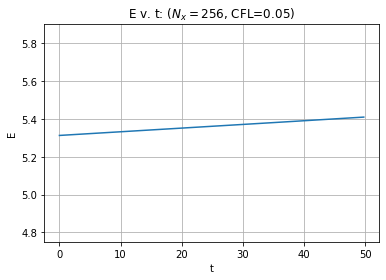

In [277]:
E = []

for i in range(len(t)):
    E.append(np.sum(solution[i,:]**2 * delta_x))
    
#E_ic = np.trapz(solution[0,:]**2, x, delta_x)
E_ic = np.sum(solution[0,:]**2 * delta_x)
#E_ic
plt.plot( t, E, '-')
plt.ylim(4.75,5.9)
plt.xlabel('t')
plt.ylabel('E')
plt.grid()
plt.title('E v. t: ($N_x={0}$, CFL={1})'.format(Nx, CFL))

#plt.savefig('Evt_CFL005', bbox_inches="tight")